# Comparative Analysis of SIFT/BoW, CNNs, and **SSL** Techniques for Image Classification
Supervised Learning A.Y 2023/24 \
_Alessio De Luca 919790_ |
_Simone Vaccari 915222_  |
_Davide Vettore 868855_

## Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, ReduceLROnPlateau

from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

## Load the Data
> The scripts have been run on the Kaggle framework, the preprocessed data is stored [here](https://www.kaggle.com/datasets/momiqb/ifoodbalanced).

In [ ]:
# Root path
path = '/kaggle/input/ifoodbalanced/'

# Read the training, validation, and test dataframes
train_df = pd.read_csv(path + 'balanced_trainset.csv')
valid_df = pd.read_csv(path + 'valset.csv')
test_df = pd.read_csv(path + 'val_labels.csv')

# Define paths for training/validation and test images
train_val_img_dir = path + 'train_set/train_set/'
test_img_dir = path + 'val_set/val_set/'

## Dataset and Dataloaders

In [ ]:
# Train on GPU if available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if train_on_gpu else "cpu")

print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
# Dataset class to properly load images
class FoodDataset(Dataset):

    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, label = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.img_dir, img_name)))

        if self.transform:
            img = self.transform(image=img)['image']

        return img, label

In [ ]:
# Define augmentations for training images
transform_train = A.Compose([
    A.Resize(width=256, height=256),      # resizing (256x256)
    A.Rotate(limit=30, p=0.5),            # random rotation in range [-30°,30°]
    A.HorizontalFlip(p=0.5),              # random horizontal flip
    A.ColorJitter (brightness=(0.8, 1), contrast=(0.8, 1), saturation=(0.8, 1), hue=0, p=0.5),    # random color jitter
    A.VerticalFlip(p=0.5),                                                                        # random vertical flip
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),                           # normalize
    ToTensorV2(),                           # convert to tensor
])

# Define validation/testing transformations
transform_valid = A.Compose([
    A.Resize(width=256, height=256),          # resize (256x256)
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),   # normalize
    ToTensorV2(),                             # convert to tensor
])

# Set batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = 4

# Initialize dataset and dataloaders
train_dataset = FoodDataset(train_df, train_val_img_dir, transform=transform_train)
valid_dataset = FoodDataset(valid_df, train_val_img_dir, transform=transform_valid)
test_dataset = FoodDataset(test_df, test_img_dir, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## SSL Model Definition

### CNN with Depthwise Separable Convolutions and Global Average Pooling

The SSL network was built upon the best-performing CNN architecture and refined for the pretext task. Specifically, it has been modified to process images with a 4x4 shuffle and predict the right order. Another difference is that this model saves the features to allow a visualization later on.

In [ ]:
# CNN network for SSL task
class SmallCNN2_SSL(nn.Module):
    def __init__(self, num_classes=251):
        super(SmallCNN2_SSL, self).__init__()

        # Shared Feature Extractor
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Depthwise Separable Convolution Block 1
        self.depthwise1 = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise1 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Depthwise Separable Convolution Block 2
        self.depthwise2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, groups=64)
        self.pointwise2 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Depthwise Separable Convolution Block 3
        self.depthwise3 = nn.Conv2d(128, 128, kernel_size=3, padding=1, groups=128)
        self.pointwise3 = nn.Conv2d(128, 256, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(256)

        # Depthwise Separable Convolution Block 4
        self.depthwise4 = nn.Conv2d(256, 256, kernel_size=3, padding=1, groups=256)
        self.pointwise4 = nn.Conv2d(256, 512, kernel_size=1)
        self.bn6 = nn.BatchNorm2d(512)

        # Depthwise Separable Convolution Block 5
        self.depthwise5 = nn.Conv2d(512, 512, kernel_size=3, padding=1, groups=512)
        self.pointwise5 = nn.Conv2d(512, 1024, kernel_size=1)
        self.bn7 = nn.BatchNorm2d(1024)

        # Max Pooling Layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier for SSL Task (Jigsaw Puzzle 4x4)
        self.classifier_ssl = self._create_classifier(16)

        # Standard Classifier for the main task
        self.fc = nn.Linear(1024, num_classes)

    # Function to create classifier for pretext task
    def _create_classifier(self, n_patches):
        return nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, n_patches)
        )

    # Common forward function for both the standard CNN and the SSL task
    # Saves features after every convolutional block for visualization
    def forward_shared(self, x):
        features = {}
        x = F.relu(self.bn1(self.conv1(x)))
        features['conv1'] = x

        x = F.relu(self.bn2(self.conv2(x)))
        features['conv2'] = x
        x = self.maxpool(x)

        x = F.relu(self.bn3(self.pointwise1(self.depthwise1(x))))
        features['depthwise1'] = x

        x = F.relu(self.bn4(self.pointwise2(self.depthwise2(x))))
        features['depthwise2'] = x
        x = self.maxpool(x)

        x = F.relu(self.bn5(self.pointwise3(self.depthwise3(x))))
        features['depthwise3'] = x

        x = F.relu(self.bn6(self.pointwise4(self.depthwise4(x))))
        features['depthwise4'] = x
        x = self.maxpool(x)

        x = F.relu(self.bn7(self.pointwise5(self.depthwise5(x))))
        features['depthwise5'] = x
        x = self.maxpool(x)

        x = self.global_avg_pool(x)
        features['global_avg_pool'] = x
        x = torch.flatten(x, 1)
        return x, features

    # Forward method for traditional CNN, here used just to plot the model summary
    def forward(self, x):
        x, _ = self.forward_shared(x)
        x = self.fc(x)                 # main task classifier
        return x

    # Forward method for SSL task
    def forward_ssl(self, x):
        x, _ = self.forward_shared(x)
        x = self.classifier_ssl(x)    # classifier for 4x4 jigsaw puzzle
        return x

    # Creates shuffled 4x4 puzzle, returning the shuffled patches and the correct order
    def _preprocess(self, images):
        batch_size, channels, height, width = images.shape
        grid_size = 4                   # 4x4 grid for the puzzle, could be modified
        # Compute patch height and width
        piece_height = height // grid_size
        piece_width = width // grid_size

        # Create a 4x4 grid of indices, where each index represents a patch's target position
        indices = torch.arange(grid_size * grid_size).view(grid_size, grid_size)

        # Initialize lists to save image patches and targets
        pieces = []
        targets = []
        for i in range(grid_size):
            for j in range(grid_size):
                # Select spatial portion of image across all the images of the batch and all channels
                piece = images[:, :, i*piece_height:(i+1)*piece_height, j*piece_width:(j+1)*piece_width]
                # Save selected patch in the list of patches
                pieces.append(piece)
                # Append the current index (target) to the list of targets (this index represents where this patch belongs in the original unshuffled grid)
                targets.append(indices[i, j].repeat(batch_size))

        # Stack the saved pieces and targets
        pieces = torch.stack(pieces, dim=1)
        targets = torch.stack(targets, dim=1)

        # Create permutation of indices from 0 to 15
        shuffled_indices = torch.randperm(grid_size * grid_size)

        # Rearrange the pieces and targets according to the shuffled indices
        shuffled_pieces = pieces[:, shuffled_indices, :, :, :]
        shuffled_targets = targets[:, shuffled_indices]

        # Reshape the shuffled pieces and targets to have a batch size of (batch_size * num_pieces)
        shuffled_pieces = shuffled_pieces.view(-1, channels, piece_height, piece_width)
        shuffled_targets = shuffled_targets.view(-1)

        return shuffled_pieces, shuffled_targets



In [ ]:
model = SmallCNN2_SSL(num_classes=251)
model.to(device)

summary(model, input_size=(3, 256, 256))

# 983,323


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           2,432
       BatchNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 32, 256, 256]           9,248
       BatchNorm2d-4         [-1, 32, 256, 256]              64
            Conv2d-5         [-1, 32, 128, 128]             320
            Conv2d-6         [-1, 64, 128, 128]           2,112
       BatchNorm2d-7         [-1, 64, 128, 128]             128
            Conv2d-8         [-1, 64, 128, 128]             640
            Conv2d-9        [-1, 128, 128, 128]           8,320
      BatchNorm2d-10        [-1, 128, 128, 128]             256
           Conv2d-11          [-1, 128, 64, 64]           1,280
           Conv2d-12          [-1, 256, 64, 64]          33,024
      BatchNorm2d-13          [-1, 256, 64, 64]             512
           Conv2d-14          [-1, 256,

## Training

In [ ]:
# Define number of training epochs
EPOCHS = 5                                 # 5 epochs is faster and performs better in the image classification task
                                           # 25 epochs takes longer but gives better results in the pretext task
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer and scheduler for shared and SSL task
optimizer_shared = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_shared = CosineAnnealingLR(optimizer_shared, T_max=len(train_loader) * EPOCHS, eta_min=1e-5)

optimizer_ssl = optim.Adam(model.classifier_ssl.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_ssl = CosineAnnealingLR(optimizer_ssl, T_max=len(train_loader) * EPOCHS, eta_min=1e-5)

In [ ]:
# Training and validation routine

def train_validate_ssl(model, device, train_loader, valid_loader, loss_fn, optimizer_shared, optimizer_ssl,
                       scheduler_shared=None, scheduler_ssl=None, epochs=EPOCHS, patience=5):
    # Initialize variables for early stopping
    best_model = None
    best_loss = np.inf
    curr_patience = patience

    # Initialize variables to save losses and accuracies
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    actual_epochs = 0
    start = time.time()

    # Training loop
    for epoch in tqdm(range(epochs)):
        actual_epochs += 1
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer_shared.zero_grad()
            optimizer_ssl.zero_grad()

            # Preprocess images for SSL task
            shuffled_pieces, targets = model._preprocess(images)
            shuffled_pieces, targets = shuffled_pieces.to(device), targets.to(device)

            # Forward pass
            outputs = model.forward_ssl(shuffled_pieces)

            # Compute loss
            loss = loss_fn(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer_shared.step()
            optimizer_ssl.step()

            train_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (preds == targets).sum().item()

        # Compute average training loss and accuracy
        train_loss /= len(train_loader)
        train_accuracy = train_correct / train_total
        epoch_train_loss.append(train_loss)
        epoch_train_accuracies.append(train_accuracy * 100)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)

                shuffled_pieces, targets = model._preprocess(images)
                shuffled_pieces, targets = shuffled_pieces.to(device), targets.to(device)

                outputs = model.forward_ssl(shuffled_pieces)

                val_loss += loss_fn(outputs, targets).item()

                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (preds == targets).sum().item()

        # Compute average validation loss and accuracy
        val_loss /= len(valid_loader)
        val_accuracy = val_correct / val_total
        epoch_val_loss.append(val_loss)
        epoch_val_accuracies.append(val_accuracy * 100)

        if scheduler_shared:
            scheduler_shared.step()
        if scheduler_ssl:
            scheduler_ssl.step()

        # Track best model and save weights if validation loss improves
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            torch.save(best_model, "/kaggle/working/best-cnn-ssl.pth")
            curr_patience = patience
            print("**BEST**", end="")
        else:
            curr_patience -= 1

        # Print training/validation statistics
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.4f}")

        # Implement early stopping
        if curr_patience <= 0:
            print("Stop training!")
            break

    end = time.time()
    print(f"Total training time: {round(end - start, 2)} seconds")

    return epoch_train_loss, epoch_val_loss, epoch_train_accuracies, epoch_val_accuracies, actual_epochs

In [ ]:
# Execute the SSL training and validation routine
epoch_train_loss, epoch_val_loss, epoch_train_accuracies, epoch_val_accuracies, actual_epochs = train_validate_ssl(
                    model, device, train_loader, valid_loader, criterion, optimizer_shared, optimizer_ssl,
                    scheduler_shared=scheduler_shared, scheduler_ssl=scheduler_ssl, epochs=EPOCHS, patience=5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>Exception ignored in: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__

Traceback (most recent call last):
  File "/opt/con

**BEST**Epoch 1/5: Train Loss: 2.1222, Train Accuracy: 0.3072, Valid Loss: 2.0149, Valid Accuracy: 0.3314


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 2/5: Train Loss: 1.9959, Train Accuracy: 0.3475, Valid Loss: 1.9524, Valid Accuracy: 0.3524


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 3/5: Train Loss: 1.9412, Train Accuracy: 0.3624, Valid Loss: 1.9158, Valid Accuracy: 0.3631


  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/op

**BEST**Epoch 4/5: Train Loss: 1.8972, Train Accuracy: 0.3759, Valid Loss: 1.9016, Valid Accuracy: 0.3676


  0%|          | 0/2597 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>
Exception ignored in: 
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3acd9fc940>    self._shutdown_workers()

self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers

  File "/opt/conda/lib/pyt

  0%|          | 0/1111 [00:00<?, ?it/s]

**BEST**Epoch 5/5: Train Loss: 1.8521, Train Accuracy: 0.3890, Valid Loss: 1.8976, Valid Accuracy: 0.3679
Total training time: 3049.86 seconds


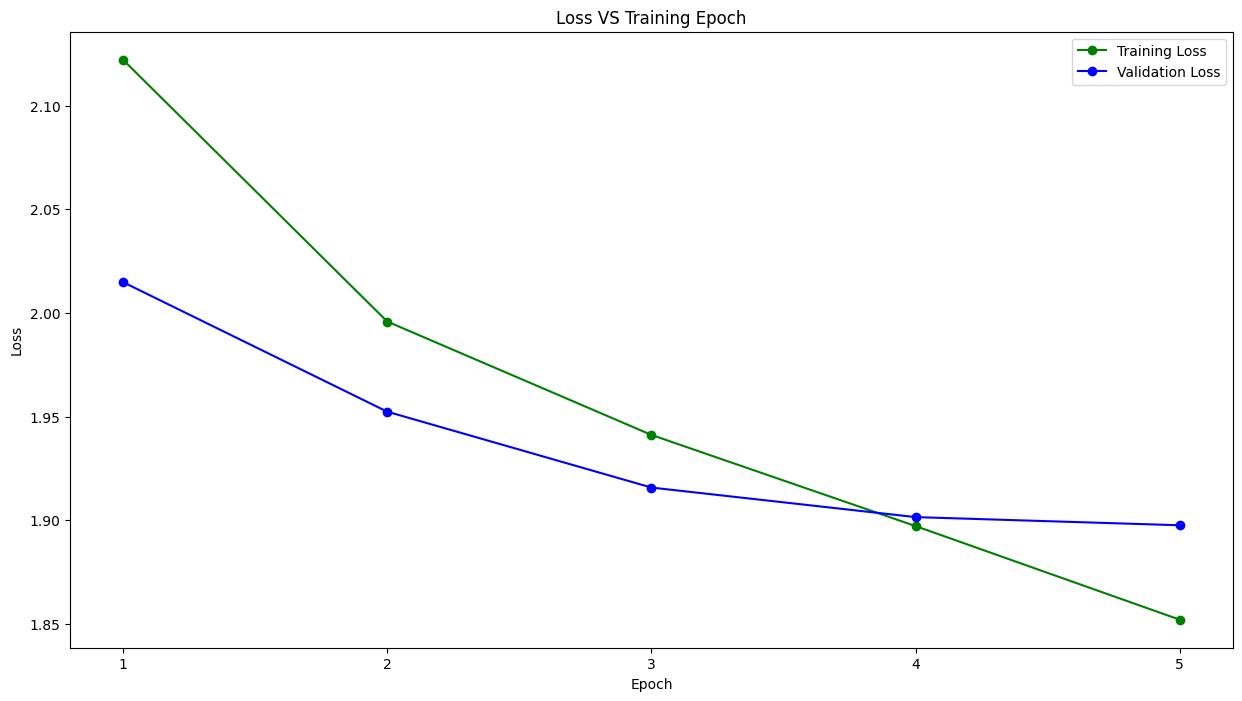

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15,8))
plt.plot(np.arange(actual_epochs)+1, epoch_train_loss, '-og', label="Training Loss")
plt.plot(np.arange(actual_epochs)+1, epoch_val_loss, '-ob', label="Validation Loss")
plt.title("Loss VS Training Epoch")
plt.xticks(np.arange(actual_epochs)+1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

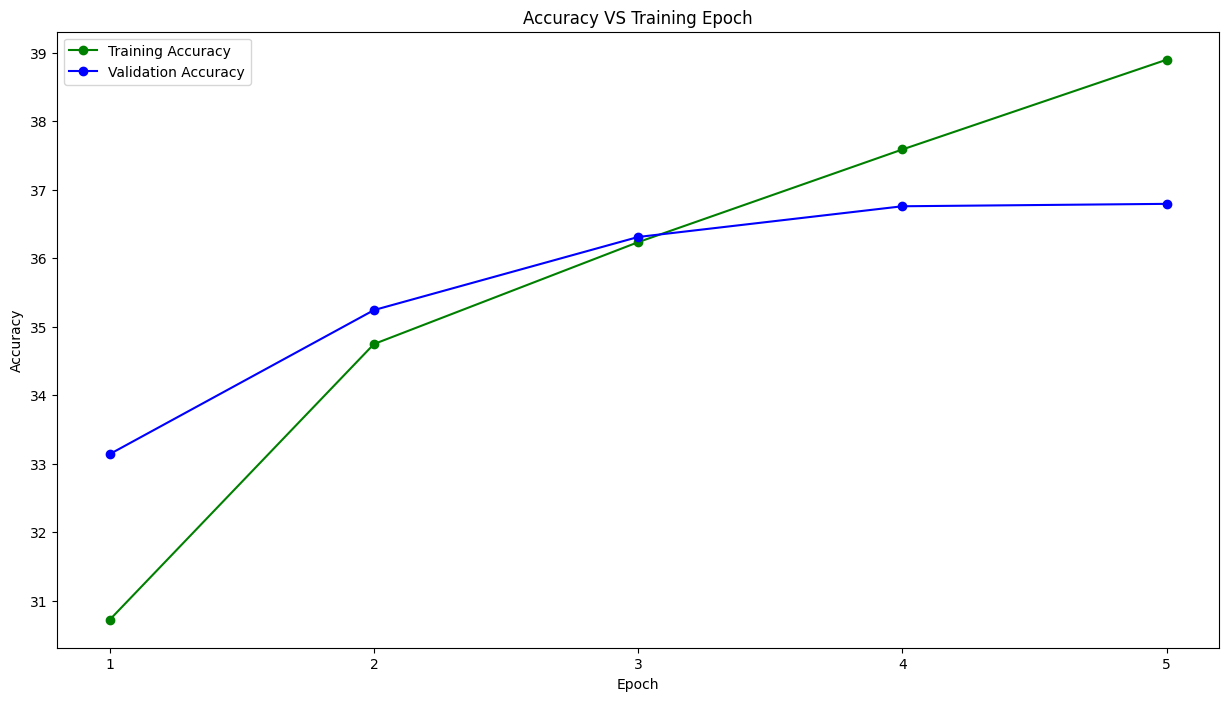

In [ ]:
# Plot training and validation accuracies
plt.figure(figsize=(15,8))
plt.plot(np.arange(actual_epochs)+1, epoch_train_accuracies, '-og', label="Training Accuracy")
plt.plot(np.arange(actual_epochs)+1, epoch_val_accuracies, '-ob', label="Validation Accuracy")
plt.title("Accuracy VS Training Epoch")
plt.xticks(np.arange(actual_epochs)+1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluation

In [ ]:
# Function to evaluate the model on the test set (pretext task)
def evaluate_model(model, test_loader):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, _ in tqdm(test_loader):
            images = images.to(device)

            # Get the shuffled pieces and corresponding new targets
            shuffled_pieces, new_targets = model._preprocess(images)
            shuffled_pieces, new_targets = shuffled_pieces.to(device), new_targets.to(device)

            # Forward pass for self-supervised learning
            outputs = model.forward_ssl(shuffled_pieces)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and targets (using new_targets after preprocessing)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(new_targets.cpu().numpy())

    # Calculate accuracy
    accuracy = (torch.tensor(all_preds) == torch.tensor(all_targets)).sum().item() / len(all_targets)

    # Calculate precision, recall, and f1 score with weighted average (weights = number of true instances for each class)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')

    # the lenght of all_preds and all_targets is 191904 which is 16 * 11994 = patches * test size
    # 375 iterations are test size / batch size

    return accuracy, precision, recall, f1


In [ ]:
# Load the best model
best_model = torch.load("/kaggle/working/best-cnn-ssl.pth", weights_only=True)  # path to external model from input or trained model in output

model.load_state_dict(best_model)
model.to(device)

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


  0%|          | 0/375 [00:00<?, ?it/s]

Accuracy: 0.3784
Precision: 0.3958
Recall: 0.3784
F1 Score: 0.3821


## Traditional classifier

In [ ]:
# Function to extract features from the images of the specified dataloader
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images, targets = images.to(device), targets.to(device)
            # Extract features
            feats = model.forward_shared(images)[0]  # use forward_shared instead of forward
            feats = feats.view(feats.size(0), -1)    # flatten features
            features.append(feats.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)


> these features were extracted from the _Global Average Pooling_ layer preceding the final classification layer. \
Extracting features from earlier layers, like the first two convolutional layers, would result in a much higher number of features compared to deeper layers. The number of features produced by each layer forms a map of dimension $ batch size * channels * height * width$. If we extracted features from an early convolutional layer, we would end up with over two million features per image, which would be impractical.

In [ ]:
# Feature extraction
train_features, train_labels = extract_features(model, train_loader, device)
val_features, val_labels = extract_features(model, valid_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

print(f"Train feature's shape: {train_features.shape}")

#  Logistic regression with z-score normalization

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

# Define the classifier
classifier_norm = LogisticRegression(max_iter=1000)
classifier_norm.fit(train_features_scaled, train_labels)

# Obtain predictions
val_preds = classifier_norm.predict(val_features_scaled)
test_preds = classifier_norm.predict(test_features_scaled)

# Compute and print metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Validation Accuracy: {accuracy_score(val_labels, val_preds) * 100:.2f}%")
print(f"Test Accuracy: {accuracy_score(test_labels, test_preds) * 100:.2f}%")
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')

  0%|          | 0/2597 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Train feature's shape: (83098, 1024)
Validation Accuracy: 8.60%
Test Accuracy: 9.52%
Validation Accuracy: 8.60%
Test Accuracy: 9.52%
Test Precision: 9.67%
Test Recall: 9.52%
Test F1 Score: 9.41%


## Visualizations

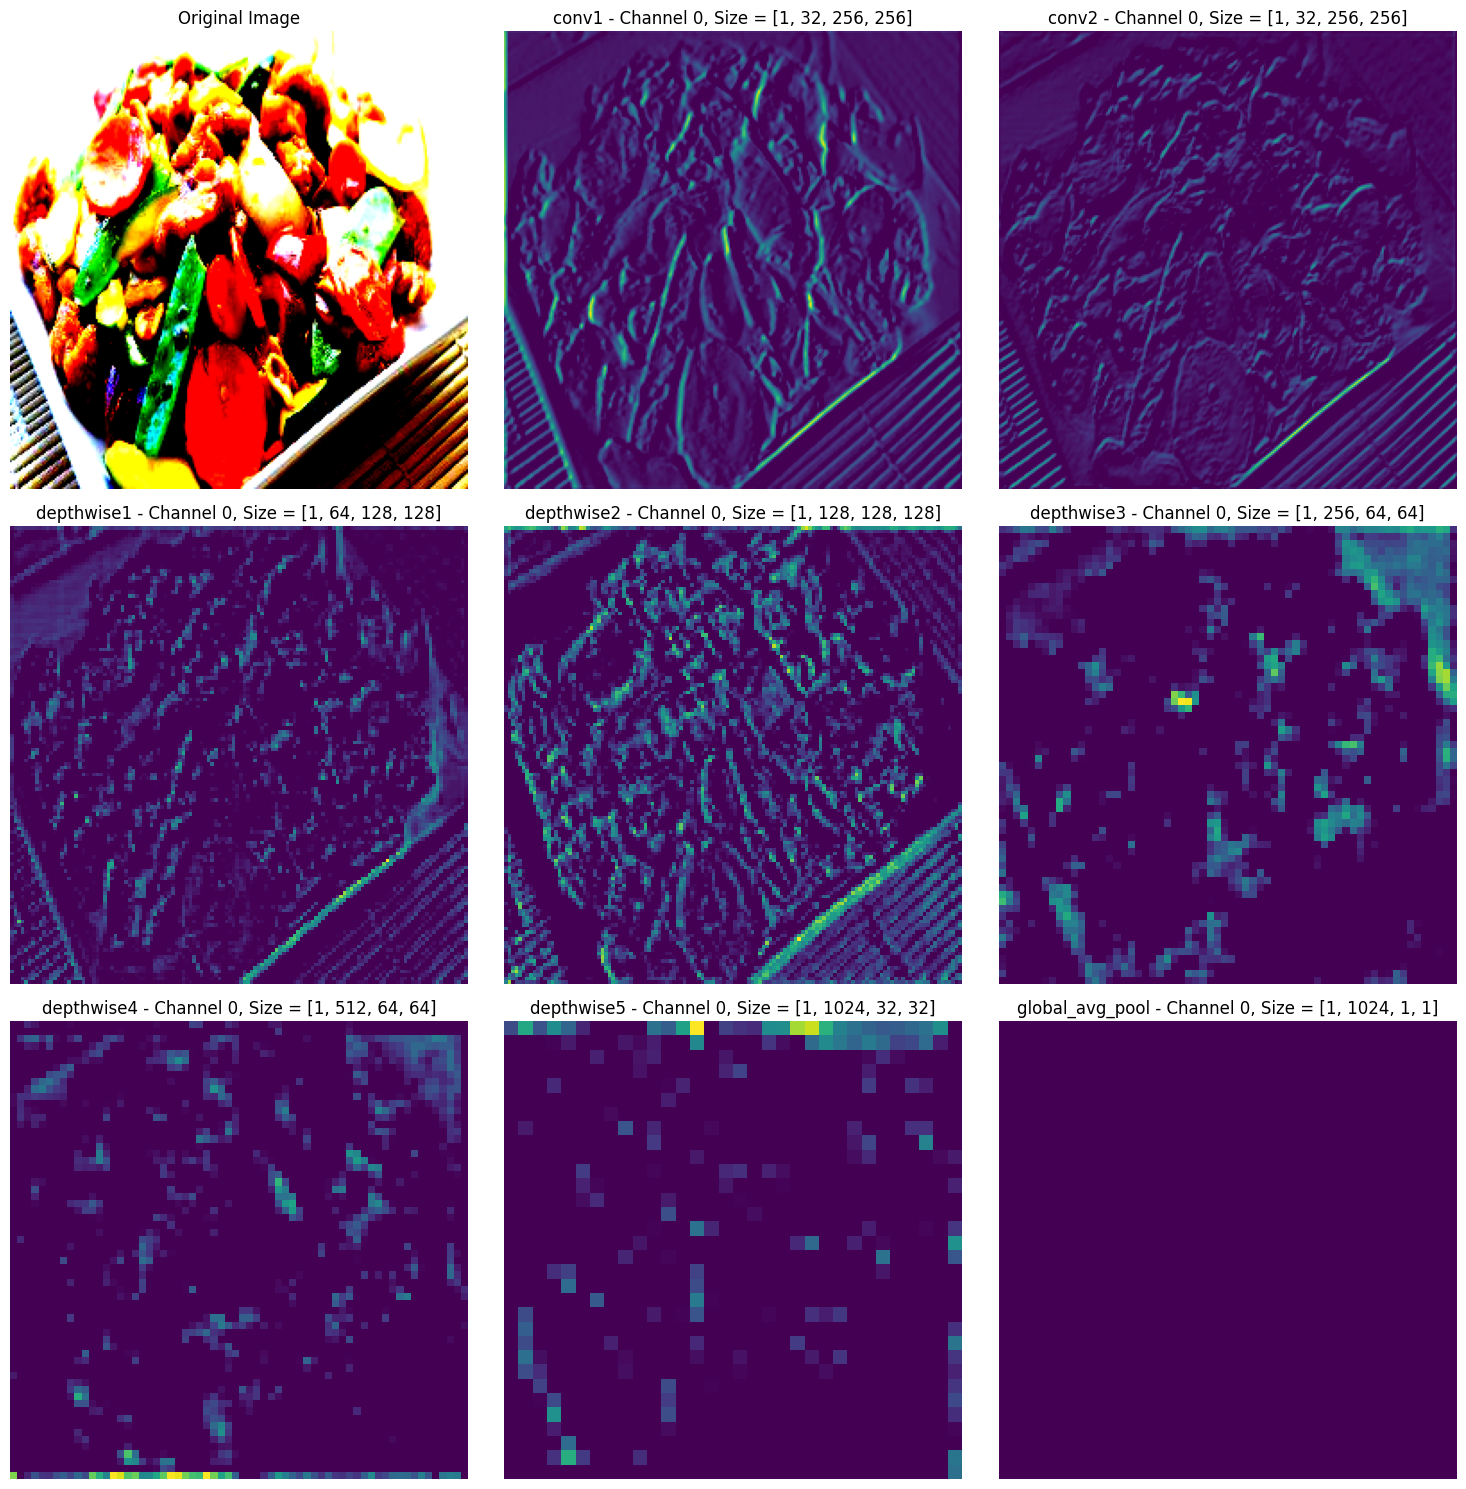

In [ ]:
# Feature maps extraxted at different stages of the network
def visualize_feature_maps(model, loader, device):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)

            single_image = images[0].unsqueeze(0).to(device)  # add batch dimension and ensure it's on the GPU

            # extract features to visualize for this single image
            _, features = model.forward_shared(single_image)

            break

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    # original image
    axes[0].imshow(single_image[0].cpu().permute(1, 2, 0).numpy())
    axes[0].set_title('Original Image')
    axes[0].axis('off')


    #features.keys() = ['conv1', 'conv2', 'depthwise1', 'depthwise2', 'depthwise3', 'depthwise4', 'depthwise5', 'global_avg_pool']
    for i, layer_name in enumerate(list(features.keys())):
        feature_map = features[layer_name]
        if feature_map.ndim == 4:  # Ensure feature_map has spatial dimensions
            # take just the first channel of each feature map
            first_channel = feature_map[0, 0].cpu().numpy()
            axes[i + 1].imshow(first_channel, cmap='viridis')
            axes[i + 1].set_title(f'{layer_name} - Channel 0, Size = {list(feature_map.shape)}')
            axes[i + 1].axis('off')

    plt.tight_layout()
    plt.show()


visualize_feature_maps(model, train_loader, device)

> In each of the layers, the network computes multiple feature maps, with the number increasing as we go deeper into the network. For example, conv1 has 32 filters, but only the first feature map is visualized here for simplicity.

In [ ]:
def plot_patches_in_grid(patches, title="4x4 Grid of Patches", grid_size=4):
    '''
    Given a list of, let's say, 16 patches, it plots them in a grid in order
    '''

    n_patches, channels, patch_height, patch_width = patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]

    # Create an empty grid to place the patches
    full_height = patch_height * grid_size
    full_width = patch_width * grid_size
    grid_image = np.zeros((full_height, full_width, channels))

    # Place each patch in the grid
    for idx in range(n_patches):
        row = idx // grid_size
        col = idx % grid_size
        patch = patches[idx].transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        grid_image[row*patch_height:(row+1)*patch_height, col*patch_width:(col+1)*patch_width, :] = patch

    # Plot the grid image
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_image)
    plt.title(title)
    plt.axis('off')
    plt.show()


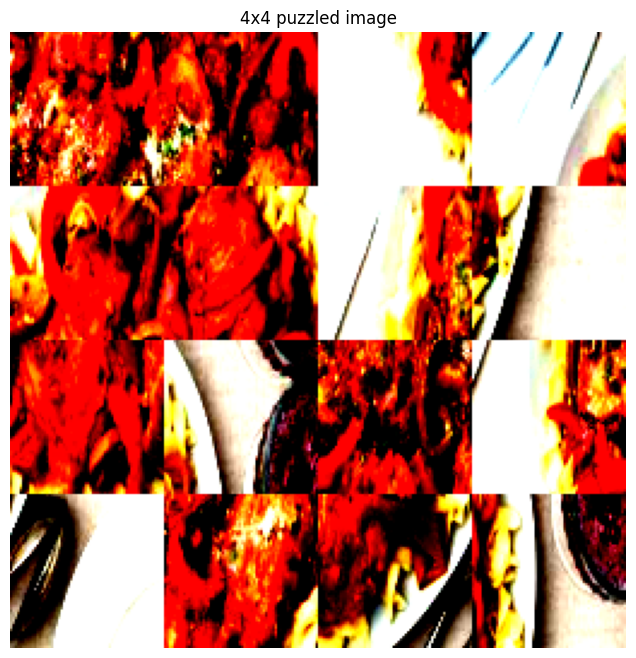

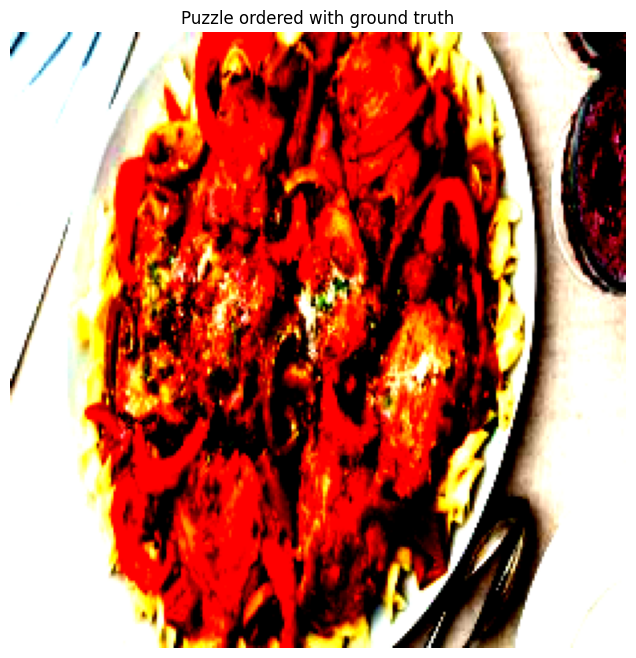

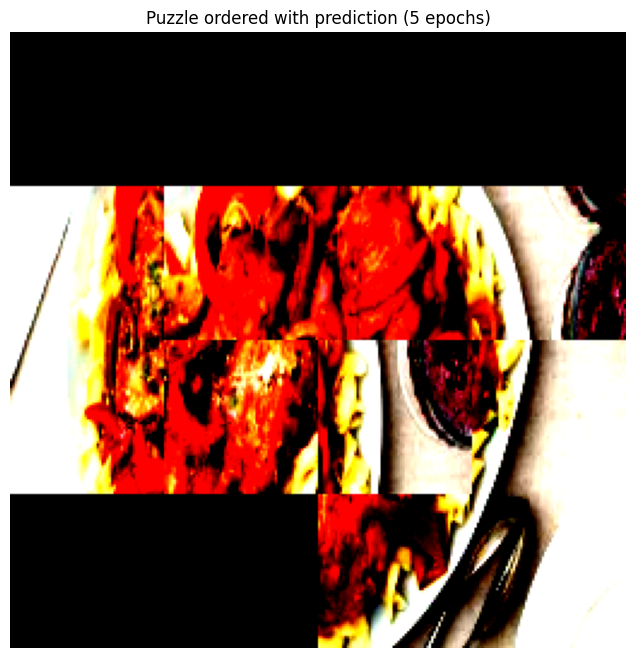

In [ ]:
def visualize_puzzles_and_solutions(model, test_loader):
    model.eval()

    with torch.no_grad():              # get a single batch
        for images, _ in test_loader:
            break

    images = images.to(device) #32, 3, 256, 256  batch of images

    puzzled_images, targets = model._preprocess(images)
    puzzled_images = puzzled_images.to(device) # 512, 3, 64, 64 - 16 mixed patches for each image
    targets = targets.to(device) # 512 - 16 real order for each image

    outputs = model.forward_ssl(puzzled_images)
    _, preds = torch.max(outputs, 1) # 512 - predicted order


    puzzle = puzzled_images[32:48].cpu().numpy()       #:16 16:32 32:48 48:64 64:80 80:96
    target = list(targets[32:48].cpu().numpy())
    prediction = list(preds[32:48].cpu().numpy())

    # puzzle
    plot_patches_in_grid(puzzle, "4x4 puzzled image")

    # ordered
    ordered_patches = np.zeros_like(puzzle)
    for i, target_idx in enumerate(target):
        ordered_patches[target_idx] = puzzle[i]
    plot_patches_in_grid(ordered_patches, f"Puzzle ordered with ground truth")

    # predicted order
    predicted_patches = np.zeros_like(puzzle)
    for i, target_idx in enumerate(prediction):
        predicted_patches[target_idx] = puzzle[i]
    plot_patches_in_grid(predicted_patches, f"Puzzle ordered with prediction (5 epochs)")


visualize_puzzles_and_solutions(model, test_loader)

> The black spaces are not plotting errors but are caused by the repetition of some indeces and absence of others. for example, the predicted order initially says that the sixt patch of the puzzle image should be in the first position [6,8,3,10,12,**0**,15,...], then the model change ideas and says that the second to lask patch should be in the first position [...7,3,**0**,8] that is actually correct, but overwrites the previous decision. We also see that the eight position is overwritten 4 times, this problem paired with the fact that some other positions are completely neglected leaves some holes in the reconstruction. The only way to avoid that is making the network way more complex and forcing it to utilize each patch only one time, either not making it overwrite stuff or allowing it to change previous predictions.
